In [ ]:
!pip install tensorflow-privacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 67.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=78a8194609f53eacbb0d3b6b477b9bfa2c6133b9993d02301db2ab96b6ed0f11
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d8

In [ ]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten , Reshape, Conv1DTranspose
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.models import Model

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold



#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data  = pd.read_csv("/content/gdrive/My Drive/dataset/data.csv")

In [ ]:
data.head(2)

,timestamp,src_ip,dst_ip,protocol,ttl,ip_len,ip_flag_df,ip_flag_mf,ip_flag_rb,src_port,...,tcp_flag_ns,tcp_flag_cwr,tcp_flag_ecn,tcp_flag_urg,tcp_flag_ack,tcp_flag_push,tcp_flag_reset,tcp_flag_syn,tcp_flag_fin,is_attack
0,"02/14/2020, 11:01:47:599181",1,18,12,26,118,1,0,0,14816,...,0,0,0,0,2,2,0,0,2,0
1,"02/14/2020, 10:53:58:393457",5,18,12,26,118,1,0,0,27432,...,0,0,0,0,2,2,0,0,2,0


In [ ]:
data.isna().sum()

timestamp         0
src_ip            0
dst_ip            0
protocol          0
ttl               0
ip_len            0
ip_flag_df        0
ip_flag_mf        0
ip_flag_rb        0
src_port          0
dst_port          0
tcp_flag_res      0
tcp_flag_ns       0
tcp_flag_cwr      0
tcp_flag_ecn      0
tcp_flag_urg      0
tcp_flag_ack      0
tcp_flag_push     0
tcp_flag_reset    0
tcp_flag_syn      0
tcp_flag_fin      0
is_attack         0
dtype: int64

In [ ]:
data.columns

Index(['timestamp', 'src_ip', 'dst_ip', 'protocol', 'ttl', 'ip_len',
       'ip_flag_df', 'ip_flag_mf', 'ip_flag_rb', 'src_port', 'dst_port',
       'tcp_flag_res', 'tcp_flag_ns', 'tcp_flag_cwr', 'tcp_flag_ecn',
       'tcp_flag_urg', 'tcp_flag_ack', 'tcp_flag_push', 'tcp_flag_reset',
       'tcp_flag_syn', 'tcp_flag_fin', 'is_attack'],
      dtype='object')

In [ ]:
try:
    data = data.drop('timestamp', axis=1)
except KeyError:
    pass

In [ ]:
data.columns

Index(['src_ip', 'dst_ip', 'protocol', 'ttl', 'ip_len', 'ip_flag_df',
       'ip_flag_mf', 'ip_flag_rb', 'src_port', 'dst_port', 'tcp_flag_res',
       'tcp_flag_ns', 'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg',
       'tcp_flag_ack', 'tcp_flag_push', 'tcp_flag_reset', 'tcp_flag_syn',
       'tcp_flag_fin', 'is_attack'],
      dtype='object')

In [ ]:
target_column = 'is_attack'
categorical_columns = [col for col in data.columns if col not in [target_column]]

In [ ]:
X = data.drop(target_column, axis=1)
y = data[target_column]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

# Reshape data for LSTM

#I now convert the scaled training set into a NP Arrays and then reshape it

#I reshaped it to be compatible with the expected inputs by LSTM model
X_train_numpy = X_train_scaled[categorical_columns].to_numpy()
X_train_lstm = X_train_numpy.reshape(X_train_numpy.shape[0], 1, X_train_numpy.shape[1])

In [ ]:
# Define the encoder part of the autoencoder
encoder_input = Input(shape=(len(categorical_columns),))
encoder_output = Dense(16, activation='relu')(encoder_input)
encoder_output = Dropout(0.5)(encoder_output)
encoder_output = Dense(8, activation='relu')(encoder_output)

# Create the encoder model
encoder_model = Model(encoder_input, encoder_output)

# Create the full autoencoder model
autoencoder_output = Dense(16, activation='relu')(encoder_output)
autoencoder_output = Dropout(0.5)(autoencoder_output)
autoencoder_output = Dense(len(categorical_columns), activation='sigmoid')(autoencoder_output)

autoencoder_model = Model(encoder_input, autoencoder_output)
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for reconstruction

# Display the autoencoder architecture
autoencoder_model.summary()

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]

    # Train the autoencoder on the current fold
    autoencoder_model_history = autoencoder_model.fit(X_train_fold, X_train_fold, epochs=3, batch_size=256, validation_data=(X_val_fold, X_val_fold))

    # Extract the encoded features from the trained autoencoder
    encoded_train_data = encoder_model.predict(X_train_fold)
    encoded_val_data = encoder_model.predict(X_val_fold)

    # Classification head on top of the encoded features
    classification_head = Sequential([
        Dense(16, activation='relu', input_shape=(8,)),  # 8 is the number of units in the encoder's output
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the classification head
    classification_head.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the classification head on the current fold
    classification_head_history = classification_head.fit(encoded_train_data, y_train.iloc[train_index],
                                                          epochs=3, batch_size=256,
                                                          validation_data=(encoded_val_data, y_train.iloc[test_index]))

    # Evaluate the classification head on the validation set
    y_val_pred = (classification_head.predict(encoded_val_data) > 0.5).astype(int)
    val_accuracy = accuracy_score(y_train.iloc[test_index], y_val_pred)
    cv_results.append(val_accuracy)

# Encode the test data using the trained autoencoder and predict using the classification head
encoded_test_data = encoder_model.predict(X_test_scaled[categorical_columns])
threshold = 0.8
y_test_pred = (classification_head.predict(encoded_test_data) > threshold).astype(int)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                340 

In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_results) / len(cv_results))

# Evaluate the autoencoder model
accuracy_autoencoder = accuracy_score(y_test, y_test_pred)
precision_autoencoder = precision_score(y_test, y_test_pred)
recall_autoencoder = recall_score(y_test, y_test_pred)
f1_autoencoder = f1_score(y_test, y_test_pred)

# Print the results for the autoencoder model
print("autoencoder Model:")
print(f"Accuracy =  {accuracy_autoencoder}")
print(f"Precision = {precision_autoencoder}")
print(f"Recall = {recall_autoencoder}")
print(f"F1 Score =  {f1_autoencoder}")

Average cross-validation loss: 0.9672536277682517
autoencoder Model:
Accuracy =  0.9264523293441187
Precision = 0.986427132879119
Recall = 0.8690275453321421
F1 Score =  0.9240132459191865


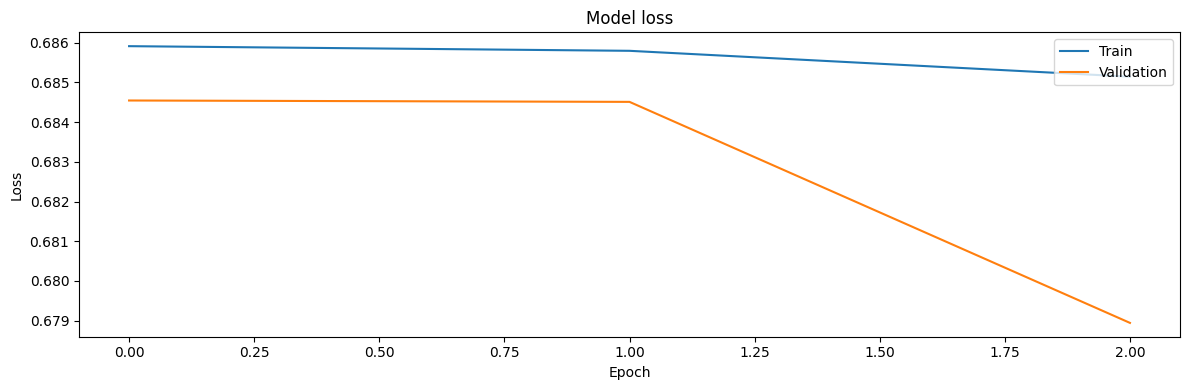

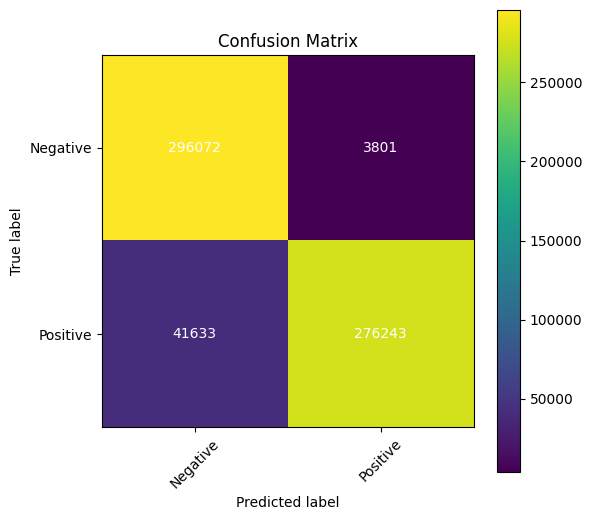

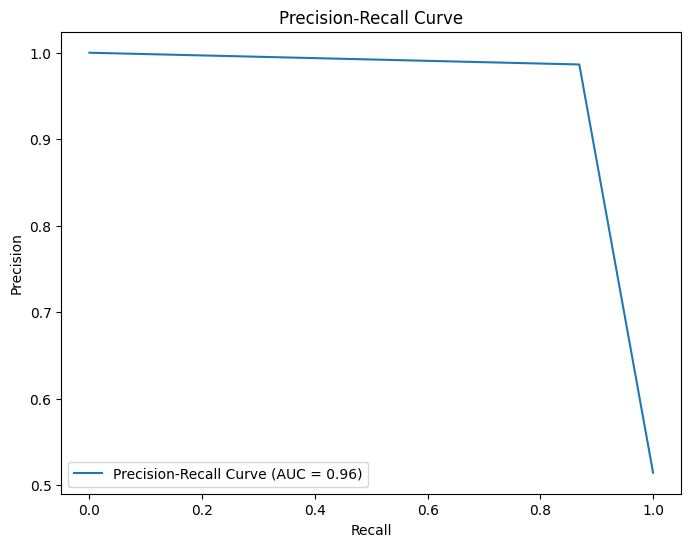

In [ ]:
# Function to plot loss curves
def plot_loss(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(autoencoder_model_history)

# Confusion Matrix
y_test_binary_true = y_test
y_test_binary_pred = (encoded_test_data > threshold).astype(int)
conf_matrix = confusion_matrix(y_test_binary_true, y_test_pred )

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Negative', 'Positive']
tick_marks = [0, 1]
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='w')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred)
area_under_curve = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {area_under_curve:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## Privacy

In [ ]:
# Define the encoder part of the autoencoder
encoder_input = Input(shape=(len(categorical_columns),))
encoder_output = Dense(16, activation='relu')(encoder_input)
encoder_output = Dropout(0.5)(encoder_output)
encoder_output = Dense(8, activation='relu')(encoder_output)

# Create the encoder model
encoder_model = Model(encoder_input, encoder_output)

# Create the full autoencoder model
autoencoder_output = Dense(16, activation='relu')(encoder_output)
autoencoder_output = Dropout(0.5)(autoencoder_output)
autoencoder_output = Dense(len(categorical_columns), activation='sigmoid')(autoencoder_output)

autoencoder_privacy =  Model(encoder_input, autoencoder_output)
autoencoder_privacy.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for reconstruction

# Display the autoencoder architecture
autoencoder_privacy.summary()

# Define differential privacy parameters
batch_size = 16
l2_norm_clip = 1.0
noise_multiplier = 1.3
num_microbatches = 1

# Create a DP optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=0.001
)

# Compile the autoencoder model with the DP optimizer and mean squared error loss
autoencoder_privacy.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

# Display the autoencoder architecture
autoencoder_privacy.summary()

# Perform 5-fold cross-validation
# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the autoencoder with DP on the current fold
    autoencoder_history_privacy = autoencoder_privacy.fit(X_train_fold, X_train_fold,
                            epochs=3,
                            batch_size=batch_size // num_microbatches,
                            validation_data=(X_val_fold, X_val_fold))

    # Extract the encoded features from the trained autoencoder
    encoded_train_data = autoencoder_privacy.predict(X_train_fold)
    encoded_val_data = autoencoder_privacy.predict(X_val_fold)

    # Classification head on top of the encoded features
    classification_head = Sequential([
        Dense(16, activation='relu', input_shape=(20,)),  # Adjust input shape to match encoder output
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the classification head
    classification_head.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the classification head on the entire training set
    classification_head_history = classification_head.fit(encoded_train_data, y_train_fold,
                                                          epochs=3, batch_size=256,
                                                          validation_data=(encoded_val_data, y_val_fold))

    # Evaluate the classification head on the validation set
    y_val_pred = (classification_head.predict(encoded_val_data) > 0.5).astype(int)
    val_accuracy = accuracy_score(y_val_fold, y_val_pred)
    cv_results.append(val_accuracy)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_14 (Dense)            (None, 16)                336       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dense_16 (Dense)            (None, 16)                144       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 20)                340 

In [ ]:
# Encode the test data using the trained autoencoder and predict using the classification head
encoded_test_data = autoencoder_privacy.predict(X_test_scaled[categorical_columns])
threshold = 0.8
y_test_pred = (classification_head.predict(encoded_test_data) > threshold).astype(int)

19305/19305 [==============================] - 29s 1ms/step


In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", np.average(cv_results))

# Evaluate the autoencoder model
accuracy_autoencoder_privacy = accuracy_score(y_test, y_test_pred)
precision_autoencoder_privacy = precision_score(y_test, y_test_pred)
recall_autoencoder_privacy = recall_score(y_test, y_test_pred)
f1_autoencoder_privacy = f1_score(y_test, y_test_pred)

# Print the results for the autoencoder model
print("autoencoder Model:")
print(f"Accuracy =  {accuracy_autoencoder_privacy}")
print(f"Precision = {precision_autoencoder_privacy}")
print(f"Recall = {recall_autoencoder_privacy}")
print(f"F1 Score =  {f1_autoencoder_privacy}")

Average cross-validation loss: 0.6450020777979406
autoencoder Model:
Accuracy =  0.48542854784062783
Precision = 0.0
Recall = 0.0
F1 Score =  0.0


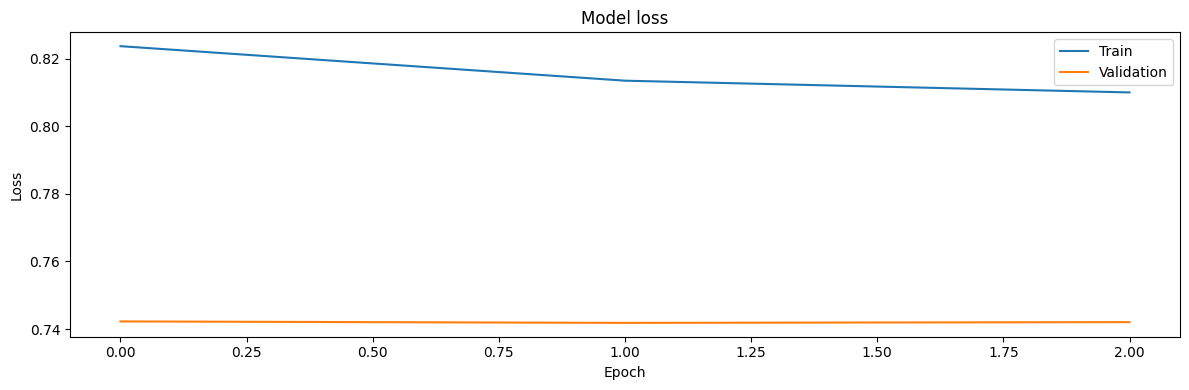

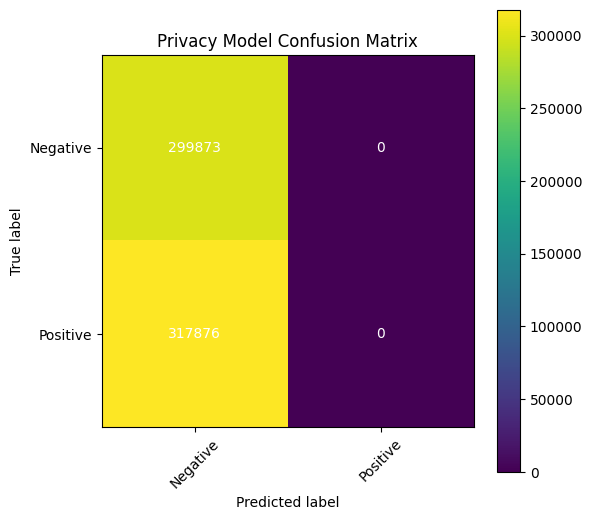

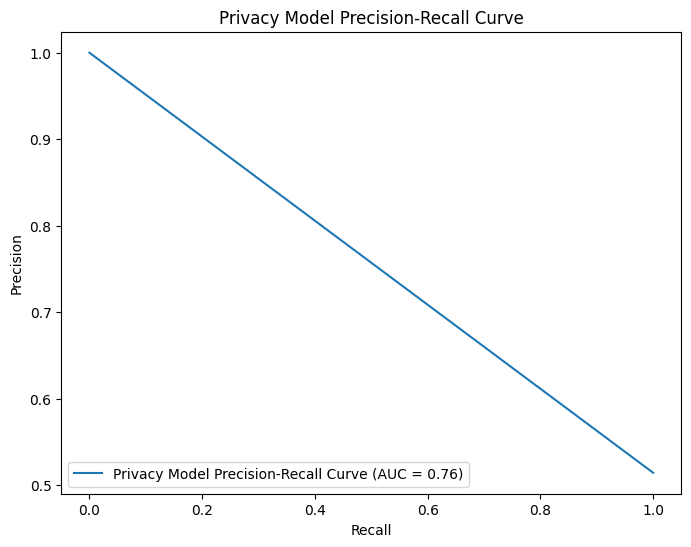

In [ ]:
# Plot loss curves
plot_loss(autoencoder_history_privacy)

# Confusion Matrix
y_test_binary_true = y_test
y_test_binary_pred = y_test_pred
conf_matrix = confusion_matrix(y_test_binary_true, y_test_binary_pred)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest')
plt.title('Privacy Model Confusion Matrix')
plt.colorbar()
classes = ['Negative', 'Positive']
tick_marks = [0, 1]
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='w')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_binary_pred)
area_under_curve = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Privacy Model Precision-Recall Curve (AUC = {area_under_curve:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Privacy Model Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# Extract trainable variables from the model
trainable_variables = autoencoder_privacy.trainable_variables

# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_scaled),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=3,
    delta=1e-5
)

In [ ]:
print(privacy_report)

DP-SGD performed over 823664 examples with 16 examples per iteration, noise
multiplier 1.3 for 3 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        15.311
    Epsilon assuming Poisson sampling (*):                      1.092

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed the actual epsilon should be
closer to this value than the conservative assumption of an arbitrary data
order.

